# Task 1
Compute the SIFT features of the given image.

a) Extract SIFT features with default parameters and show the keypoints on the image. Hint:
There are existing OpenCV functions you can use for this (see suggestions below).

b) To achieve better visualization of the keypoints, reduce the number of keypoints.
Hint: Vary the parameter contrastThreshold or nfeatures so that the number of keypoints
becomes about 10% of all default keypoints.
Show the result images obtained in a) and b) in your Jupyter notebook and include a brief
description of the approach you used for b).

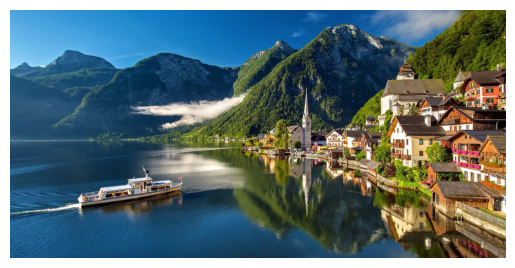

In [17]:
# Part A
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load file
file = 'Hallstatt.png'
img = cv2.imread(file, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(img)


3213


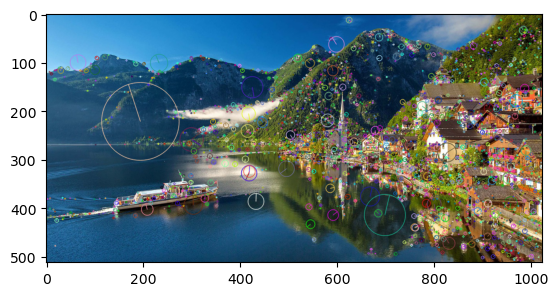

In [18]:
# Get sift points
sift = cv2.SIFT_create()
img2 = img.copy()
kp = sift.detect(img2,None)

img2 = cv2.drawKeypoints(img2,kp,img2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print(len(kp))
plt.imshow(img2)


322


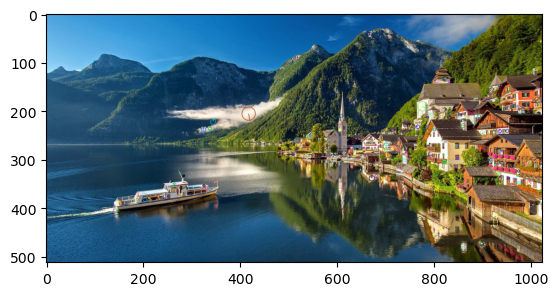

In [19]:
#Reduce to 10% of sift kp
img3 = img.copy()

sift3 = cv2.SIFT_create(nfeatures=int(len(kp)*.1))
kp3 = sift3.detect(img3,None)
img3 = cv2.drawKeypoints(img3,kp3,img3,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print(len(kp3))
plt.imshow(img3)


I just took 10% of the number of keypoints generated in part A and made sure that only 10% of those features were generated in b

# Task 2
Distort the image and recompute the SIFT features.

a) Add pepper noise to the given image. Hint: The scikit-image library has a utility function to
add random noise of various types to images.

b) Extract the SIFT features from the noisy image and show the keypoints using the same
parameter setting as for Task 1 (for the reduced number of keypoints).

c) Inspect the keypoints visually: Are the keypoints of the noisy image roughly the same as
those of the original image? What does this imply?

Show the result images obtained in a) and b) in your Jupyter notebook and include your
answers to the questions in c).

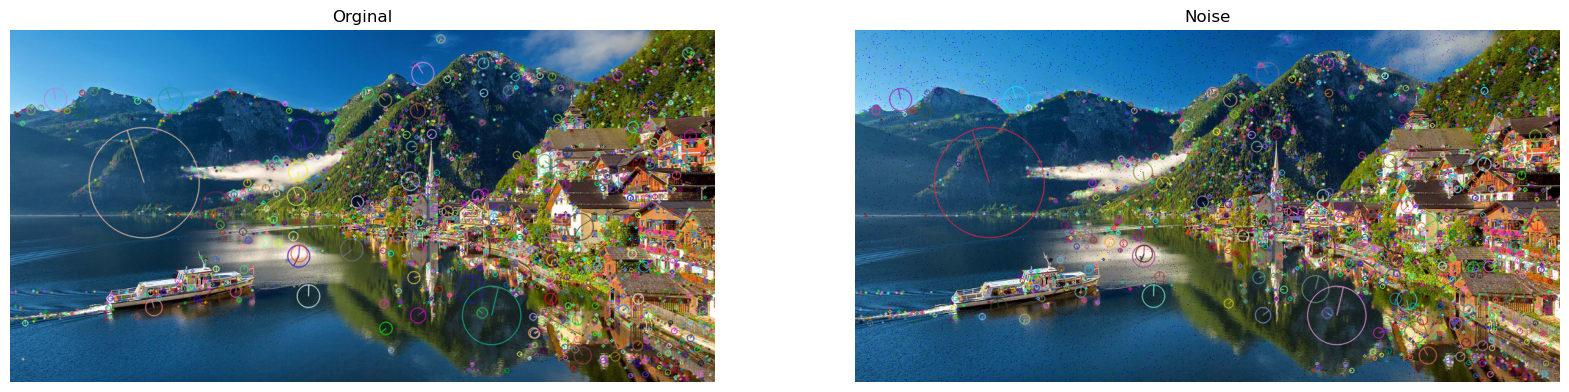

In [20]:
import skimage as ski

imgNoise = ski.util.random_noise(img, mode='pepper', amount=0.01)
imgNoise = ski.img_as_ubyte(imgNoise)
siftT2 = cv2.SIFT_create()
kpT2 = siftT2.detect(imgNoise,None)
imgNoise = cv2.drawKeypoints(imgNoise,kpT2,imgNoise,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# Display the first image on the left subplot
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1), plt.imshow(img2), plt.title('Orginal'), plt.axis('off')

# Display the second image on the right subplot
plt.subplot(1, 2, 2), plt.imshow(imgNoise), plt.title('Noise'), plt.axis('off')
plt.show()




Evidently the SIFT features are effectively identical which proves that SIFT extraction is well resistant to noise.